In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from glob import glob

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

2024-03-24 20:36:50.854750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 20:36:50.854865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 20:36:50.999732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_dir = '/kaggle/input/cricket-shot-dataset/data'

In [5]:
class_names = os.listdir(data_dir)
class_names

['pullshot', 'sweep', 'drive', 'legglance-flick']

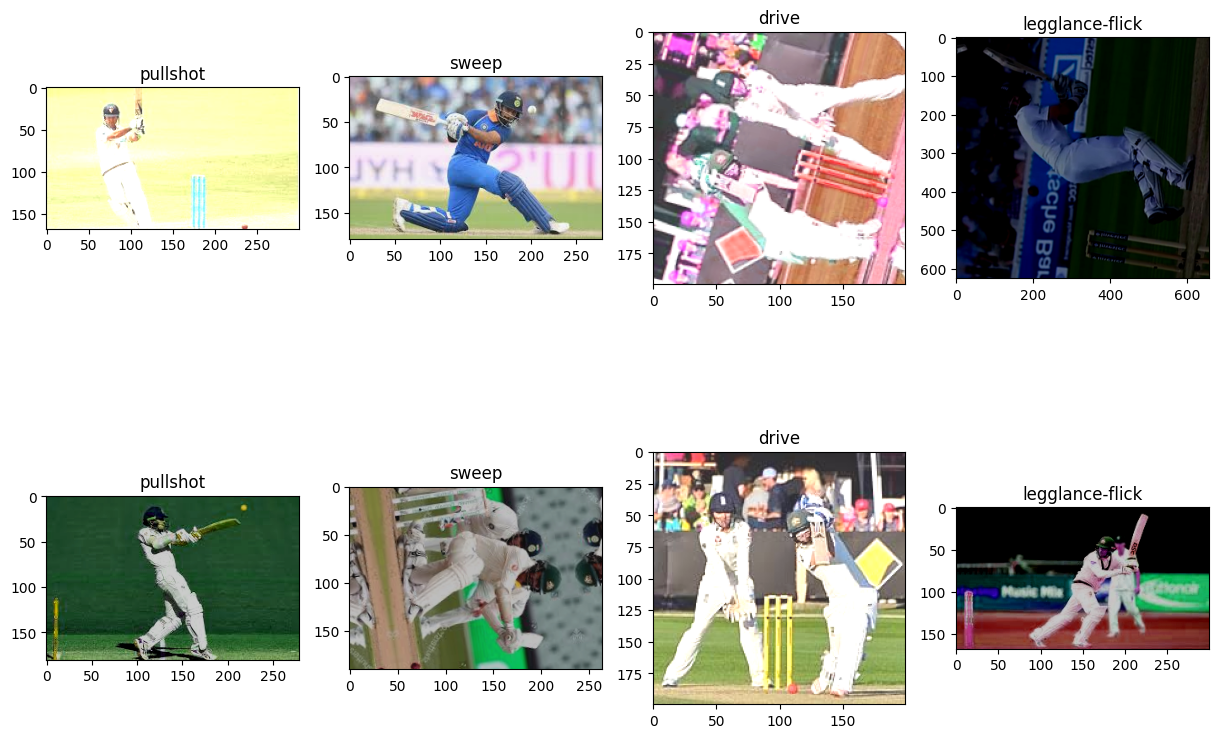

In [6]:
def visualize_images(image_paths):
    max_rows = 2
    max_cols = 4
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(max_rows, max_cols, figsize=(15,10))
    idx = 0
    for col in range(max_cols):
        for row in range(max_rows):
            img = cv2.imread(image_paths[idx])
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            class_name = image_paths[idx].split('/')[-2]
            axs[row, col].imshow(image)
            axs[row, col].set_title(class_name)
            idx += 1
    plt.show()

image_paths = []
for class_name in class_names:
    paths = random.sample(glob(os.path.join(data_dir, class_name)+'/*.png'), k=2)
    image_paths.extend(paths)
visualize_images(image_paths)

In [7]:
image_paths = []
class_labels = []

for class_name in class_names:
    paths = glob(os.path.join(data_dir, class_name, "*.png"))
    image_paths.extend(paths)
    class_labels.extend([class_name] * len(paths))

df = pd.DataFrame(data={"image_path": image_paths, "label": class_labels})

In [8]:
print(df['label'].value_counts())

label
pullshot           1228
drive              1173
sweep              1100
legglance-flick    1085
Name: count, dtype: int64


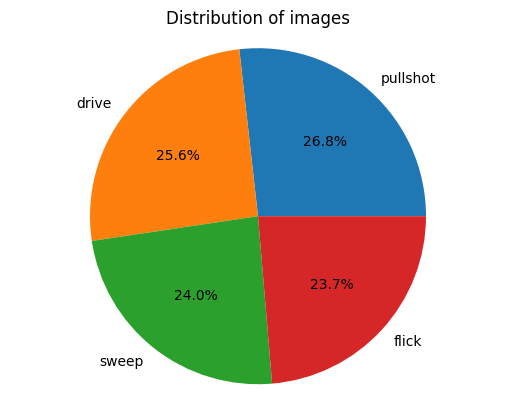

In [9]:
labels = ['pullshot', 'drive', 'sweep', 'flick']
sizes = [1228, 1173, 1100, 1085]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title("Distribution of images")

plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X = df # Contains all columns.
y = df[['label']] # Dataframe of just the column on which to stratify.

# Split original dataframe into train and temp dataframes.
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      test_size=0.30,
                                                      random_state=40)

# Split the temp dataframe into val and test dataframes.
df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                  y_temp,
                                                  stratify=y_temp,
                                                  test_size=0.5,
                                                  random_state=40)

In [11]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Testing Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

BATCH_SIZE = 32
IMG_SHAPE = (256, 256, 3)
num_classes = len(class_names)
IMG_SHAPE_2 = (224, 224, 3)

# We create a Learning Rate Reducer that will reduce the learning rate by half if the validation loss does not decrease in 4 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose=1)

# We stop the model training if we see no improvement (reduction in validation loss) for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

LR = 0.0003
train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

valid_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)

test_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing


In [22]:
train_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing, horizontal_flip=True, vertical_flip=True)
val_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)
test_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)

In [23]:
inception_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception_model_output = inception_model.output

# Add additional layers on top of the InceptionV3 model
x = Flatten()(inception_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

# Add the final output layer with softmax activation
inception_output = Dense(num_classes, activation='softmax')(x)

# Create the final model with InceptionV3 as the base and the added layers
inception_final = Model(inception_model.input, inception_output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
LR = 0.0003
inception_final.compile(optimizer=Adam(learning_rate=LR),
                       loss=CategoricalCrossentropy(),
                       metrics=['accuracy'])

In [25]:
history_inception = inception_final.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
  1/101 ━━━━━━━━━━━━━━━━━━━━ 2:43:59 98s/step - accuracy: 0.1562 - loss: 1.4592

W0000 00:00:1711313807.271774      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.4014 - loss: 1.2963

W0000 00:00:1711313897.187587      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.4030 - loss: 1.2931 - val_accuracy: 0.2863 - val_loss: 12.7429 - learning_rate: 3.0000e-04
Epoch 2/10


W0000 00:00:1711313910.937736      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - accuracy: 0.9139 - loss: 0.2828 - val_accuracy: 0.7863 - val_loss: 1.7556 - learning_rate: 3.0000e-04
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 247ms/step - accuracy: 0.9538 - loss: 0.1395 - val_accuracy: 0.9913 - val_loss: 0.0377 - learning_rate: 3.0000e-04
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.9788 - loss: 0.0784 - val_accuracy: 0.9462 - val_loss: 0.2306 - learning_rate: 3.0000e-04
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 249ms/step - accuracy: 0.9807 - loss: 0.0885 - val_accuracy: 0.9666 - val_loss: 0.1527 - learning_rate: 3.0000e-04
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - accuracy: 0.9798 - loss: 0.0870 - val_accuracy: 0.8866 - val_loss: 0.4907 - learning_rate: 3.0000e-04
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9726 - loss: 0.1173
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
101/101 ━━━━━━━━━━━━━━━━━━━━ 27s 252ms/step - accura

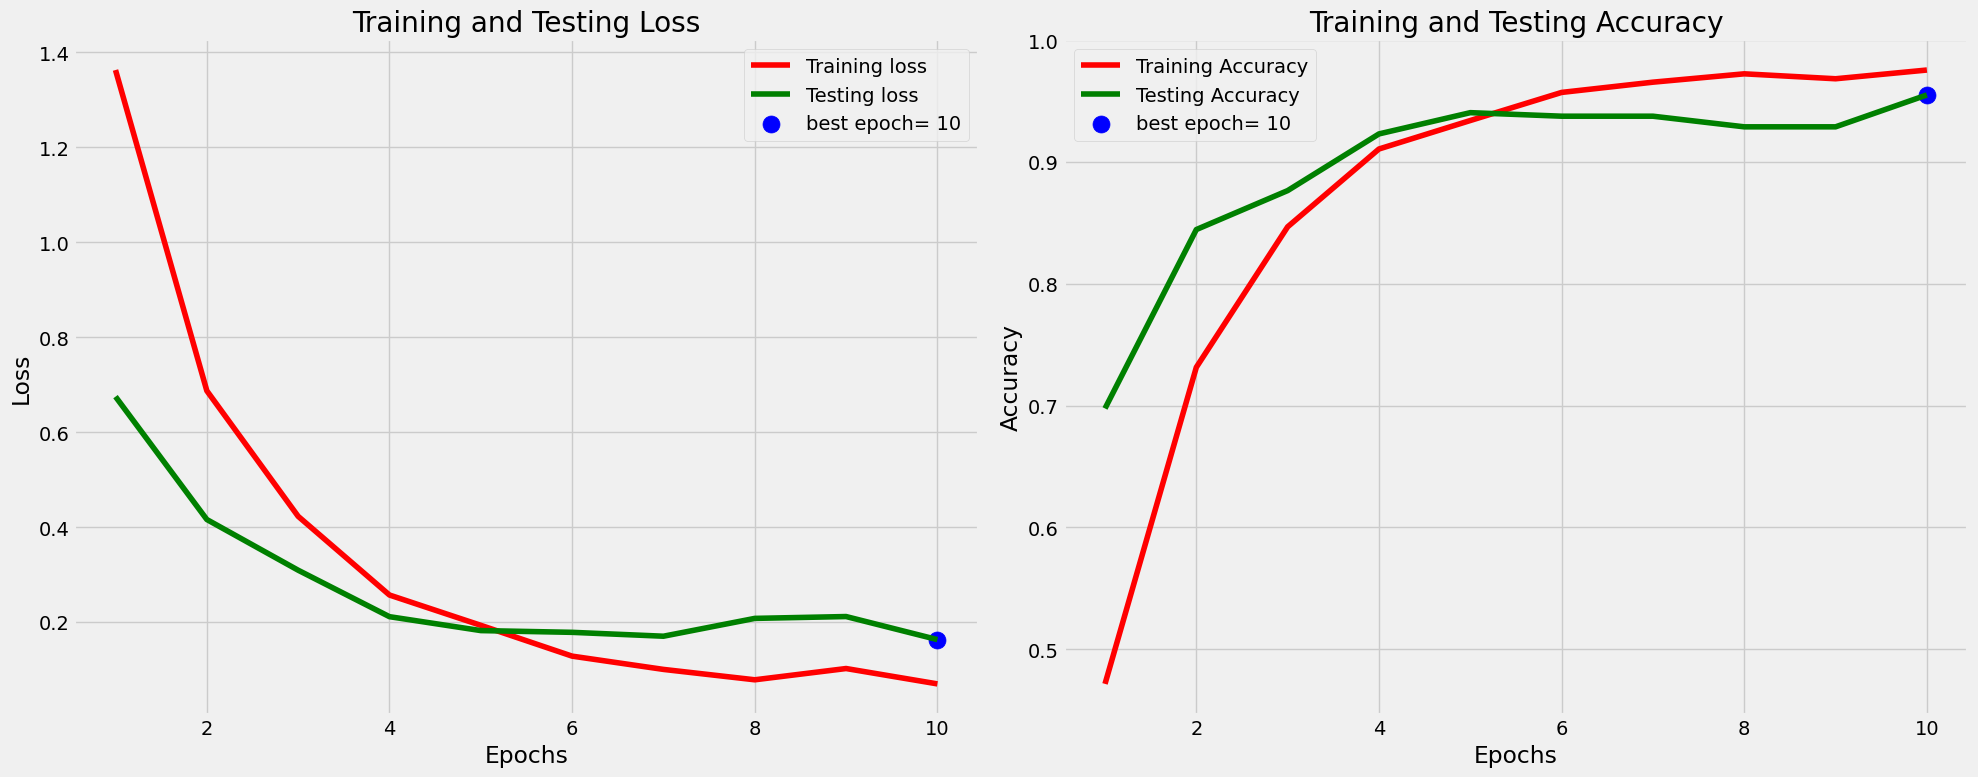

In [26]:
plot_training(history_efficientnet)